# Religious Migration Analysis 1990-2020
Author: add later\
*Data Source:* Pew Research Center (https://www.pewresearch.org/dataset/dataset-religious-composition-of-the-worlds-migrants-1990-2020/)

This analysis explores global religious migration patterns from 1990-2020, examining how migration flows have influenced religious demographics across different geographical scales.

*Dataset Structure:*
- 26712 rows
- 9 columns
- Hierarchical data (Country -> Regional -> Global levels)
- Time period: 1990-2020 (5-year intervals)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
migration = pd.read_csv('data/Incoming_and_Outgoing_Migrant_Counts.csv', thousands=',')

#sns.set_palette("colorblind")
sns.set_palette("muted")
sns.set_style('whitegrid', {"grid.color": ".95"})

### Function definitions

In [5]:
def explore_data_quality(df):
    """
    Perform initial data quality checks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to analyze
        
    Returns:
    --------
    dict
        Dictionary containing data quality metrics
    """
    quality_report = {
        'missing_values': df.isnull().sum(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
        'data_types': df.dtypes
    }
    return quality_report

def format_numbers(ax):
    """
    Format y-axis numbers to use comma separators instead of scientific notation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to format
        
    Returns
    -------
    None
        Modifies the axis object in place

    Example
    -------
    >>> fig, ax = plt.subplots()
    >>> plot_data(ax)
    >>> format_numbers(ax)
    """
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

def make_autopct(values):
    """
    Creates a function to format percentage labels for pie charts.
    Only shows labels for segments larger than 5% of the total.
    
    Parameters:
    ----------
    values : array-like
        The values used to generate the pie chart
        
    Returns:
    -------
    function
        A function that takes a percentage value and returns:
        - Formatted percentage string (e.g., "25%") for values > 5%
        - Empty string for values ≤ 5%
        
    Example:
    -------
    >>> values = [30, 45, 15, 10]
    >>> plt.pie(values, autopct=make_autopct(values))
    """
    def my_autopct(pct):
        return f'{pct:.0f}%' if pct > 5 else ''  # only show if >5%
    return my_autopct

### Cleaning the data

In [7]:
explore_data_quality(migration)

{'missing_values': Direction      0
 Year           0
 Country        0
 Religion       0
 Count          0
 Percent        0
 Region         0
 level          0
 countrycode    0
 dtype: int64,
 'unique_values': {'Direction': 2,
  'Year': 7,
  'Country': 239,
  'Religion': 8,
  'Count': 834,
  'Percent': 955,
  'Region': 7,
  'level': 3,
  'countrycode': 239},
 'data_types': Direction       object
 Year             int64
 Country         object
 Religion        object
 Count           object
 Percent        float64
 Region          object
 level            int64
 countrycode      int64
 dtype: object}

In [8]:
#Changing the following column type to 'category' for memory optimization: Direction, Religion, Region, Level 
migration = migration.astype({
    'Direction': 'category',
    'Religion': 'category',
    'Region': 'category',
    'level': 'category',
})

#Standardized column names to lowercase
migration.columns = migration.columns.str.lower()

#Replacing values of '< 10,000' with 5,000 for numerical calculations. The number 5000 was chosen as a midpoint since we don't have the actual numbers
migration['count'] = migration['count'].replace('< 10,000', '5000')

#Remove commas and convert 'count' to numbers
migration['count'] = migration['count'].str.replace(',', '')
migration['count'] = pd.to_numeric(migration['count'])

## I. Global Migration Analysis

The story of global migration is a compelling one of change. Between 1990 and 2020, much of the world saw considerable increases in incoming and outgoing migration. This has dramatically shaped religious demographics around and within different regions and countries. Although some religious groups remain dominant, the story becomes a bit more nuanced when looking more deeply into those groups.

### Data Prep

In [12]:
# Global Migration Trends 1990 to 2020
global_level_df = migration[(migration['level'] == 3) & # filter for global level data
                          (migration['religion'] != 'All') & # remove 'All' value. 'All' rows total every religion
                          (migration['direction'] == 'Incoming')].copy() #Filter for only 'Incoming' to avoid doubling the actual number of migrants
global_level_df['religion'] = global_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts
order = global_level_df.groupby('religion', observed=True)['count'].mean().sort_values(ascending=False).index # Storing sort order in variable for barplot

# Migration Growth Rates by Religious Group 1990-2020
global_growth_df = global_level_df.pivot_table(index='religion', columns='year', values='count') #Pivot the dataframe with years as column, migration count as values and religion as index
global_growth_df['growthrate'] = (global_growth_df[2020] - global_growth_df[1990]) / global_growth_df[1990] * 100 #Add growth rate column
global_growth_df['abs_diff'] = global_growth_df[2020] - global_growth_df[1990] # Add an absolute difference column

# Global Migration Growth Rates by Religious Group Before and After 2005
growth_periods_df = global_growth_df.copy()
growth_periods_df['post_2005'] = round((growth_periods_df[2020] - growth_periods_df[2005]) / growth_periods_df[2005] * 100)
growth_periods_df['pre_2005'] = round((growth_periods_df[2005] - growth_periods_df[1990]) / growth_periods_df[1990] * 100)
growth_periods_df.reset_index(inplace=True)
growth_periods_df = pd.melt(growth_periods_df, 
                           id_vars=['religion'], 
                           value_vars=['pre_2005', 'post_2005'], 
                           var_name='period', 
                           value_name='growth rate')

### What has global migration looked like over the years?

**Key Findings**:
- Global migration increased 83.4% from 1990 to 2020.
- Christians and Muslims represent the largest migration groups.
- Despite smaller volume, Buddhist migration showed the highest growth rate of 137%.
- Muslims had the largest migration growth rate post-2005.
- Buddhists were the only group to see a decline in migration growth post-2005.
- Jewish migration remains generally low.


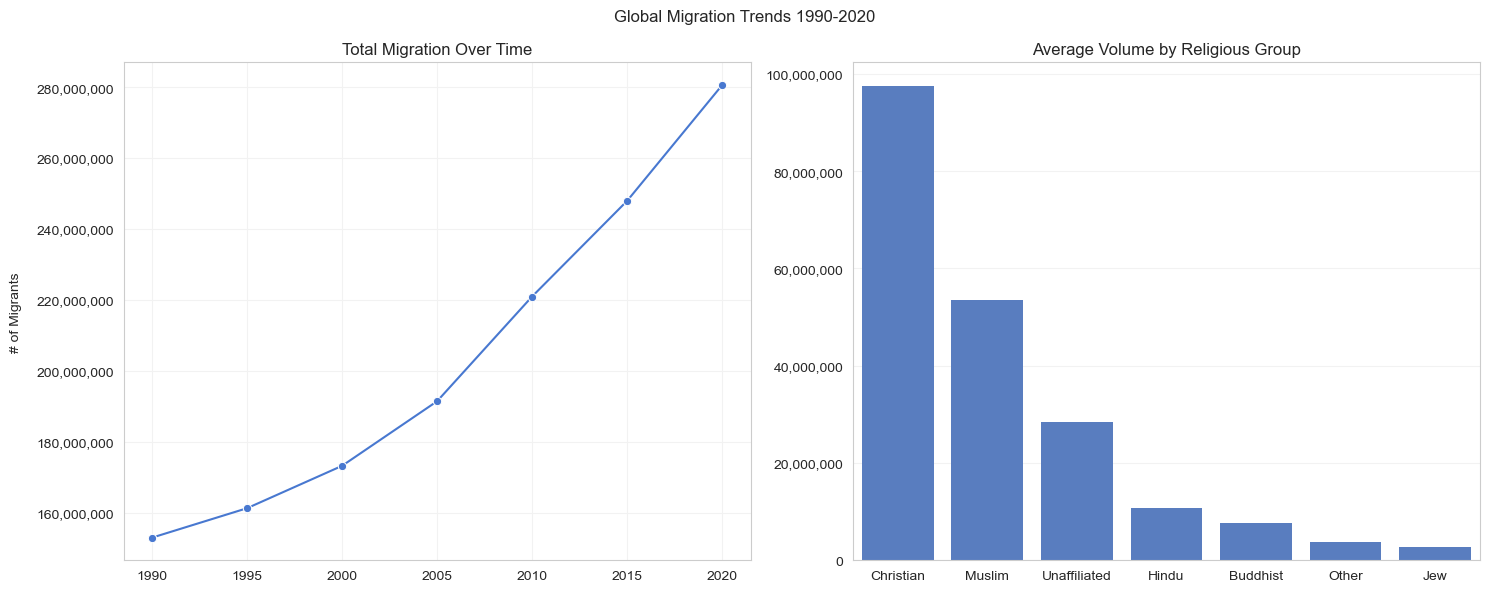

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=global_level_df, 
             x='year', y='count', 
             errorbar=None, marker='o', 
             estimator=sum, ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('# of Migrants', labelpad=10)
ax1.set_xlabel('')
ax1.set_title('Total Migration Over Time')

sns.barplot(data = global_level_df, 
            x='religion', y='count', 
            errorbar=None, order=order, 
            linewidth=0, ax=ax2)
format_numbers(ax2)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Average Volume by Religious Group')

plt.suptitle('Global Migration Trends 1990-2020')
plt.tight_layout()

Starting with global migration, we see that the landscape changed dramatically over three decades. Movement has only increased, accelerating after 2005. Of that, Christians represent the largest number of migrants in the world, averaging just under 100 million people, followed by Muslims at around 50 million and the religiously unaffiliated at 30 million. However, these volume numbers tell only part of the story. Christians may lead in total numbers, but examining growth rates reveals surprising dynamics about which religious groups are expanding most rapidly - patterns that will help us understand both regional and country-level changes.

### How have global growth rates changed?

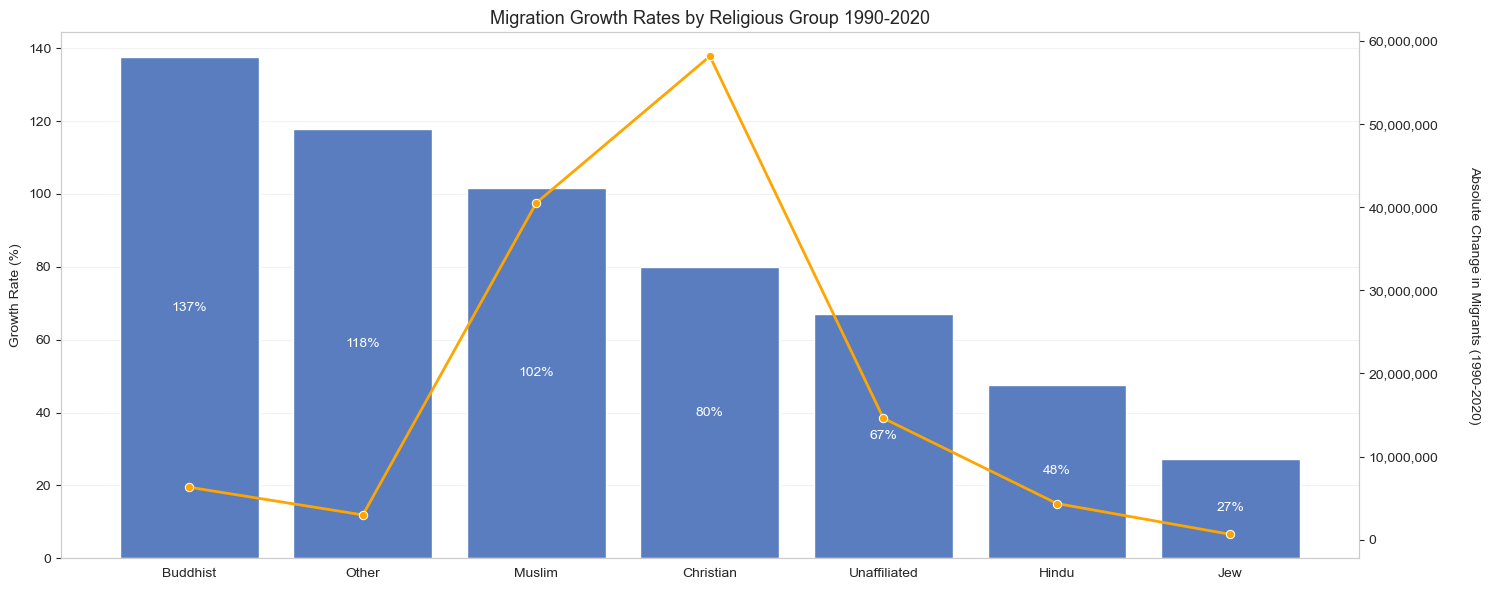

In [17]:
fig, ax1 = plt.subplots(figsize=(15, 6))
sns.barplot(data=global_growth_df, 
            x='religion', y='growthrate',
           order=global_growth_df.sort_values('growthrate', ascending=False).index,
           ax=ax1)

ax1.set_xlabel('')
ax1.set_ylabel('Growth Rate (%)')
ax1.bar_label(ax1.containers[0], label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

ax2 = ax1.twinx()
sns.lineplot(data=global_growth_df,
             x='religion', y='abs_diff',
             ax=ax2, color='orange',
             linewidth=2, marker='o')

format_numbers(ax2)
ax2.set_ylabel('Absolute Change in Migrants (1990-2020)', labelpad=30, rotation=270)
ax2.grid(alpha=0)


plt.title('Migration Growth Rates by Religious Group 1990-2020', size=13)
plt.tight_layout()

Growth rates, on the other hand, are an entirely different story from volume migration. While Buddhists are one of the lowest in volume among all religious groups, they also consist of the largest percentage growth rate, with an astonishing 137% increase between 1990 and 2020. In the same way, individuals grouped as "Other", which had very small total migration, showed a huge growth rate of 118%, with Muslims following closely. Hindus and Jewish groups saw more modest increases of 48% and 27%, respectively.

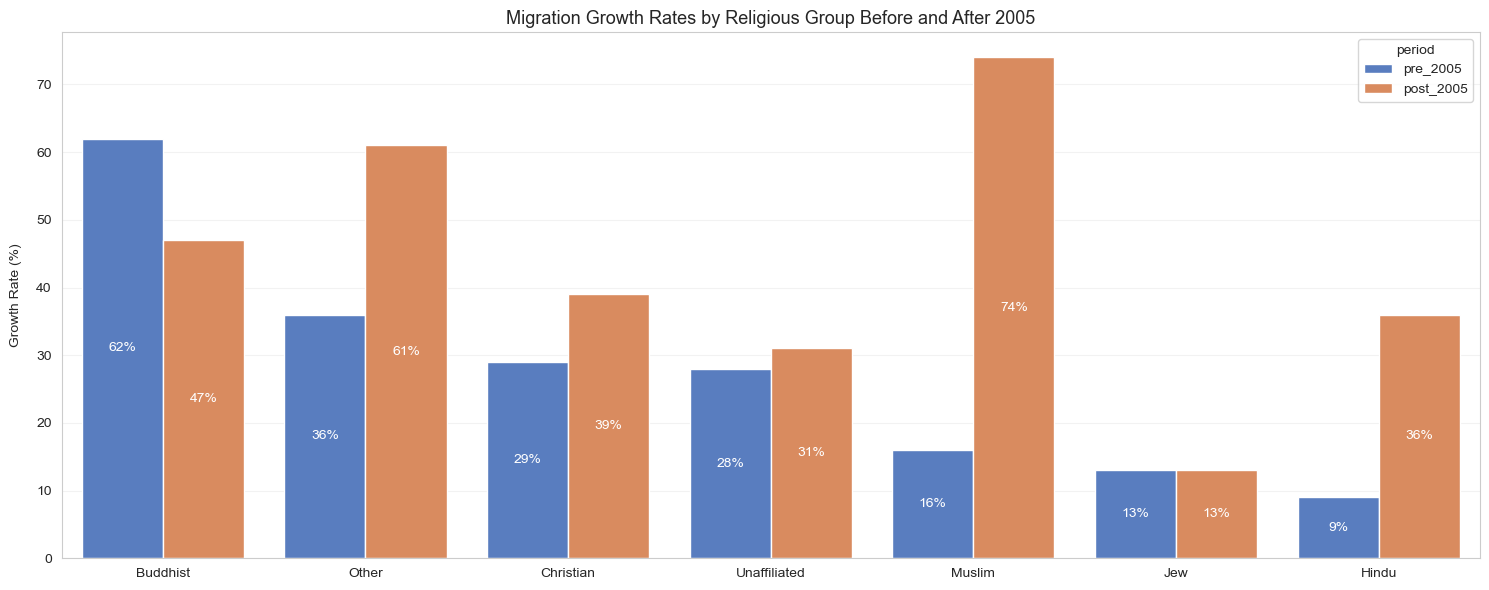

In [19]:
plt.figure(figsize=(15, 6))

order = growth_periods_df[growth_periods_df['period'] == 'pre_2005'].sort_values('growth rate', ascending=False)['religion']

ax = sns.barplot(growth_periods_df, 
                 x='religion', y='growth rate', 
                 hue='period', order=order)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')

plt.xlabel('')
plt.ylabel('Growth Rate (%)', labelpad=10)
plt.title('Migration Growth Rates by Religious Group Before and After 2005', size=13)
plt.tight_layout()

In the previous analysis on global migration, we found that the year 2005 was the turning point in world migration. When splitting the data by pre- and post-2005, most religious groups see their largest growth beyond the year 2005. The Muslim population in particular saw the biggest swing of all, growing at a low of 16 percent before 2005 and rocketing to a high of 74 percent afterwards. Hindu migration follows a similar trend, increasing about 27% in the post-2005 period. On the contrary, Buddhists present an intriguing reversal: despite showing the highest overall growth rate of 137%, they were the only group whose migration actually decreased by 15% after 2005, suggesting a significant shift in migration patterns from Asia-Pacific during this period. The Jewish population stands out for its consistency; it maintained relatively steady, moderate growth rates through both periods.

While overall global migration gives us a decent view of overall movement, diving into regional analysis may help us better understand the drivers behind the varying patterns..

## II. Regional Analysis

### Data Prep

In [23]:
# Regional Migration Patterns 1990-2020
region_level_df = migration[migration['level'] == 2].copy()
region_level_df['region'] = region_level_df['region'].cat.remove_categories(['Global'])

# Overall Net Migration by Region 1990-2020
pivoted_region_level = region_level_df.pivot_table(
    values='count', 
    columns='direction', 
    index='region').astype('int') #pivoting region_level_df to focus on incoming vs outgoing by region
net_diff = pivoted_region_level['Incoming'] - pivoted_region_level['Outgoing']

# Regional Net Migration Trends Show Growing Disparities 1990-2020
pivoted_region_year_df = region_level_df.pivot_table(values='count', columns='direction', index=['region', 'year'])
pivoted_region_year_df['net_migration'] = pivoted_region_year_df['Incoming'] - pivoted_region_year_df['Outgoing']
net_migration_df = pivoted_region_year_df.reset_index(['region', 'year'])

# Distribution of Major Religious Groups in Regional Migration
major_groups = ['Christian', 'Muslim', 'Unaffiliated'] #storing top 3 religions by average migration volume
major_religions_regions_pivoted = (region_level_df[region_level_df['religion'].isin(major_groups)]
                            .pivot_table(index=['region', 'religion'], 
                                       values='percent')
                            .reset_index())

major_religions_regions_pivoted['religion'] = major_religions_regions_pivoted['religion'].cat.remove_categories(['All', 'Buddhist', 'Hindu', 'Jew', 'Other'])

# Distribution of Other Religious Groups in Regional Migration
other_groups = ['Buddhist', 'Hindu', 'Jew', 'Other']
other_religions_regions_pivoted = (region_level_df[
    (region_level_df['religion'].isin(other_groups))
    ]
    .pivot_table(index=['region', 'religion'], 
                values='percent')
    .reset_index())
other_religions_regions_pivoted['religion'] = other_religions_regions_pivoted['religion'].cat.remove_categories(['All', 'Christian', 'Muslim', 'Unaffiliated'])

### What can regional patterns tell us?

**Key Findings**:
- Europe and Asia-Pacific show the highest migration volumes.
- Asia-Pacific experiences mostly outgoing migration.
- North America is the largest net receiver of migrants.
- Christian migration dominates most regions.
- Asia-Pacific has the highest religious diversity.


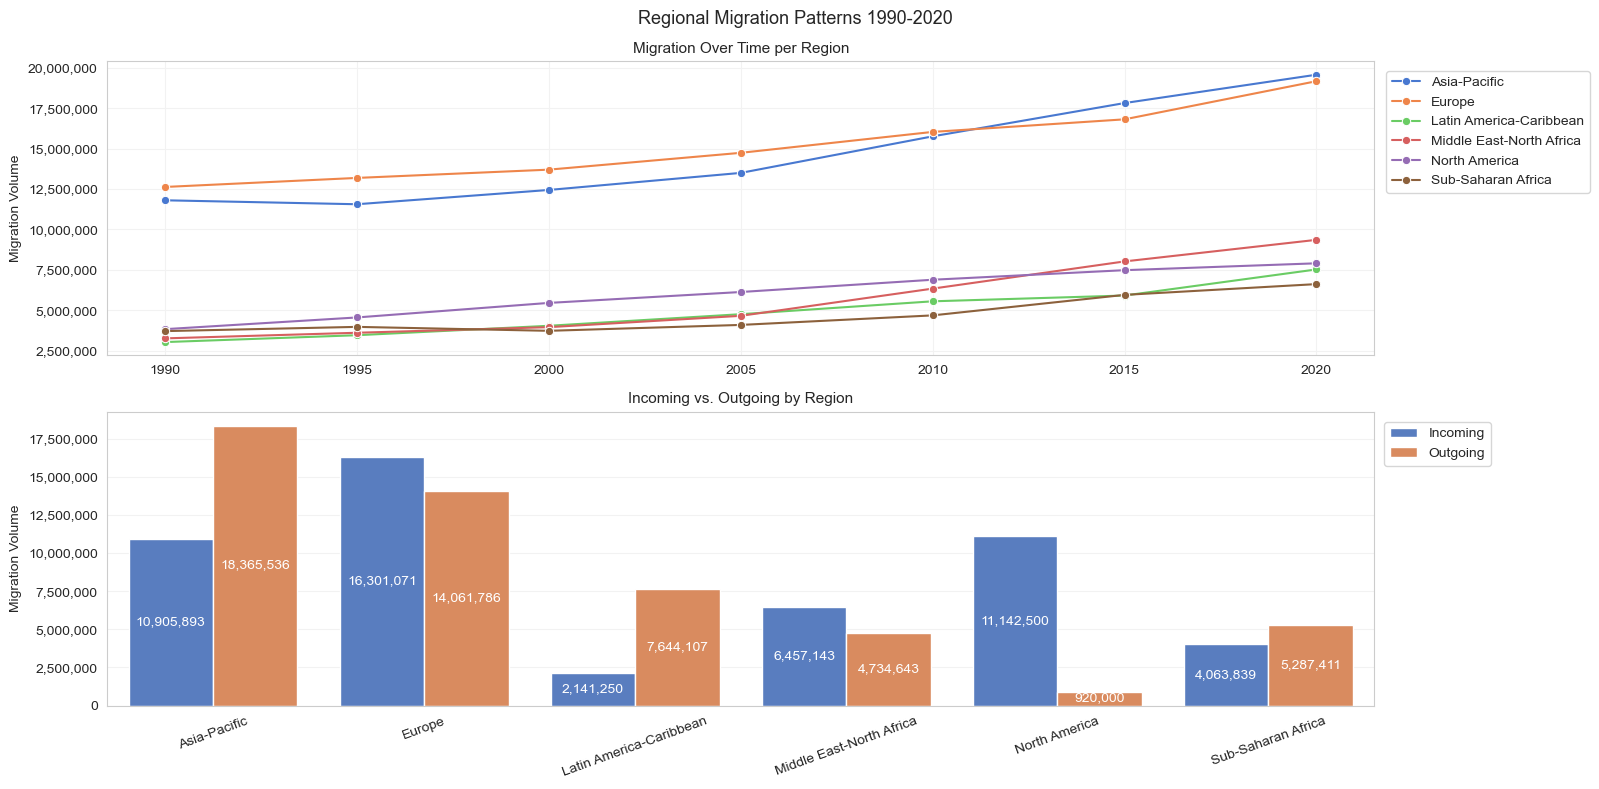

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))  # Make figure wider
plt.subplots_adjust(right=0.85)  # Leave room for legend

sns.lineplot(data=region_level_df, 
             x='year', y='count', 
             hue='region', errorbar=None, 
             marker='o', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Migration Volume')
ax1.set_title('Migration Over Time per Region', size=11)
format_numbers(ax1)
ax1.legend(loc='center', bbox_to_anchor=(1.09, 0.76))

sns.barplot(data=region_level_df, 
            x='region', y='count', 
            errorbar=None, hue='direction', 
            ax=ax2)
format_numbers(ax2)
for container in ax2.containers:
    ax2.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:,.0f}')
ax2.set_xlabel('')
ax2.set_ylabel('Migration Volume')
ax2.set_title('Incoming vs. Outgoing by Region', size=11)

plt.xticks(rotation=20)
ax2.legend(loc='center', bbox_to_anchor=(1.05, .89))

plt.suptitle('Regional Migration Patterns 1990-2020', size=13)
plt.tight_layout()

From 1990 to 2020, migration trends reflect steady increases throughout every region, with noticeable distinctions. Until about 2010, Europe led in migration volume after which Asia-Pacific overtook them; both regions have maintained much higher volumes than the rest of the world. In the other regions, including North America and Sub-Saharan Africa, the same pattern is shown on a smaller scale: 3 million migrants in 1990 to 6-9 million by 2020.

In addition, distinct regional characteristics emerge when the balance of incoming versus outgoing migration is examined. Asia-Pacific shows high volume but most of its migration is predominantly outward; Europe takes in more than it sends out. North America has consistently positive net migration, maintaining steady growth even through 2005 - a period when regions like Asia-Pacific and the Middle East/North Africa experienced large shifts in their migration patterns.

### Which regions send versus receive migrants?

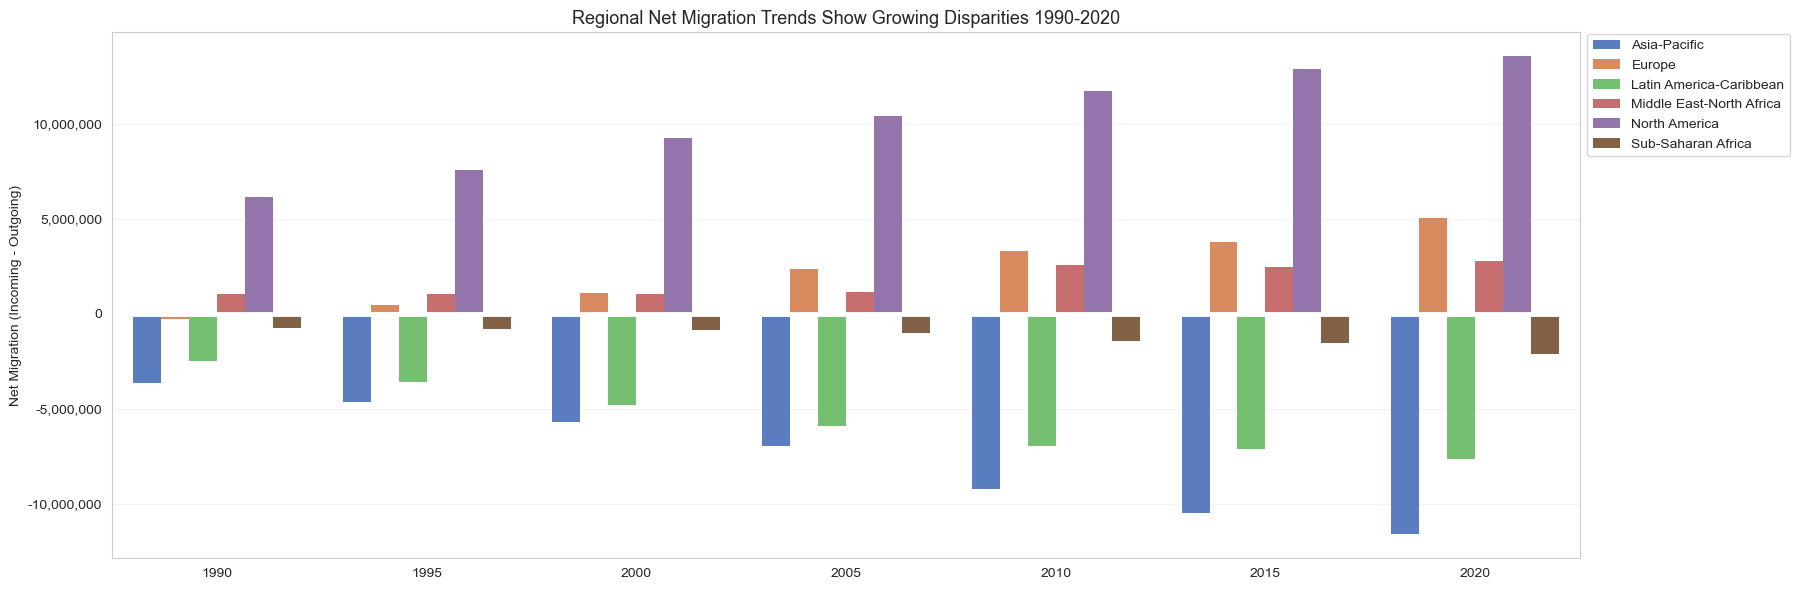

In [29]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(net_migration_df, 
                 x='year', 
                 y='net_migration', 
                 hue='region', linewidth=0)
format_numbers(ax)
plt.ylabel('Net Migration (Incoming - Outgoing)')
plt.xlabel('')
plt.title('Regional Net Migration Trends Show Growing Disparities 1990-2020', size=13)

plt.axhline(y=0, color='white', linestyle='-', linewidth=3.5)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1.01));

These volume patterns take on new meaning when we examine net migration - the balance between incoming and outgoing flows.The disparity between North America and Asia-Pacific becomes apparent. North America has constantly been the largest receiver of migrants, with the positive net migration growing from 6 million to over 13 million during the study period. By contrast, Asia-Pacific and Latin America-Caribbean are increasingly significant sending/outgoing regions and in the latter the net losses increased dramatically from 3.6 to around 12 million, whereas Europe and the Middle East/ North Africa remain as regions with a relatively low positive net migration but stable. In Sub-Saharan Africa the net losses have remained small yet persistent.

### How does religious diversity vary by region?

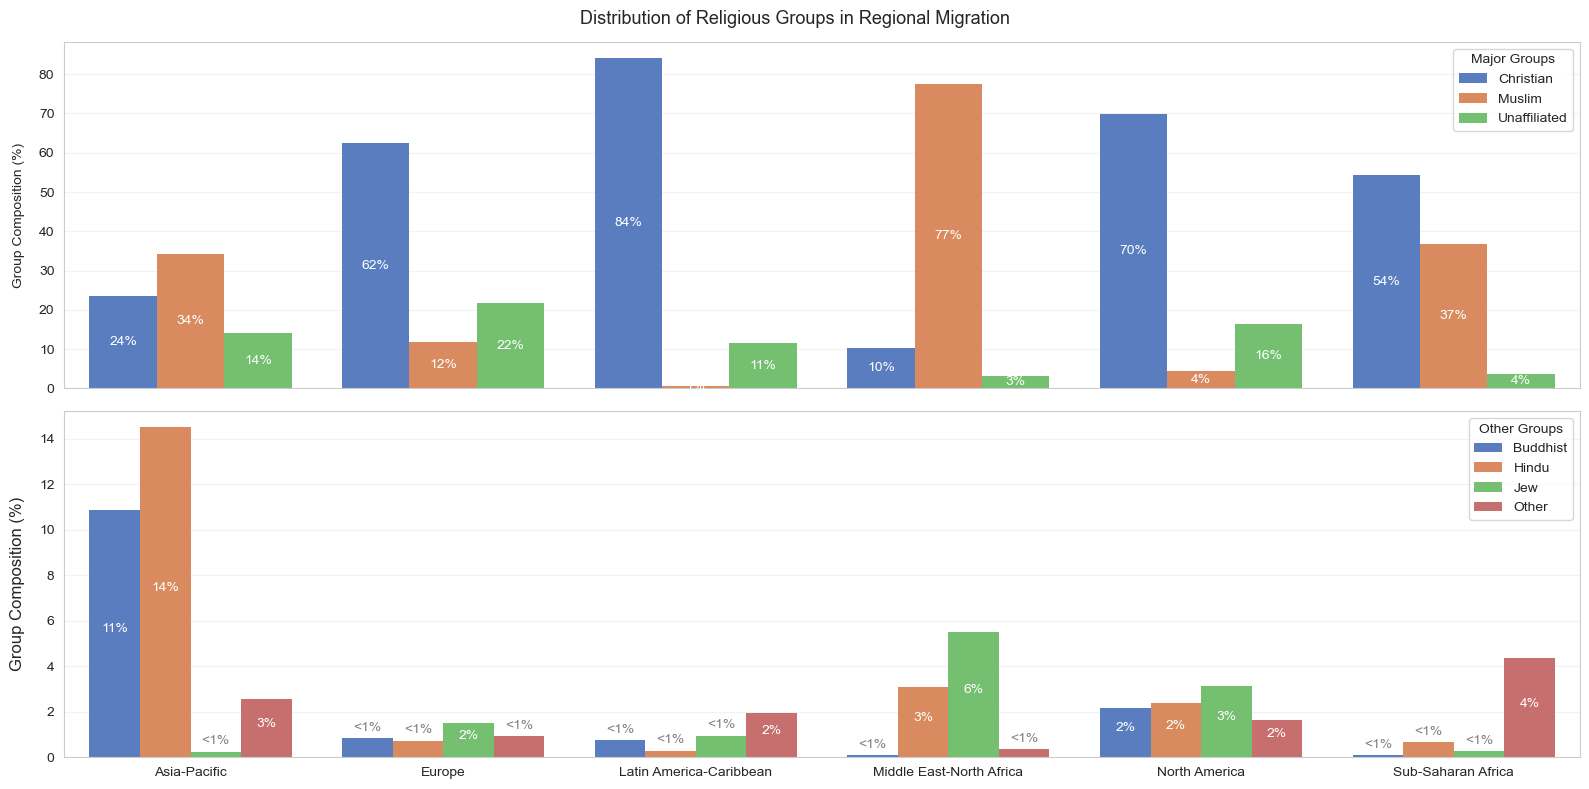

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

sns.barplot(data=major_religions_regions_pivoted, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0,
                   ax=ax1)

for container in ax1.containers:
    ax1.bar_label(container, label_type='center', color='white', fmt=lambda x: f'{x:.0f}%')
    
format_numbers(ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Group Composition (%)', labelpad=10)
ax1.legend(title='Major Groups')


sns.barplot(data=other_religions_regions_pivoted, 
                 x='region', 
                 y='percent', 
                 hue='religion',
                linewidth=0, ax=ax2)


for container in ax2.containers:
    # Handle values >= 1%
    ax2.bar_label(container, label_type='center', color='white',
                fmt=lambda x: f'{x:.0f}%' if x > 1 else '', 
                padding=3)
    # Handle values < 1%
    ax2.bar_label(container, label_type='edge', color='gray',
                fmt=lambda x: '<1%' if x <= 1 else '', 
                padding=3)
    
format_numbers(ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Group Composition (%)', labelpad=10, size=12)
ax2.legend(title='Other Groups')

plt.suptitle('Distribution of Religious Groups in Regional Migration', size=13)
plt.tight_layout()

Building on the global religious patterns we observed earlier, regional migration flows contain distinct religious compositions that help explain the varying growth rates. While Christians dominate most regions, reflecting their global majority, the significant Buddhist and Hindu populations in Asia-Pacific illuminate why these groups showed such dramatic growth rates globally. Jewish migration is most prominent in Middle East/North Africa, while other regions have a relatively small percentage of minor religious groups.

Regional trends paint a broader picture, but analysis at the country level illustrates specific forces shaping these trends. Ten countries, in particular, emerge as the primary drivers of global religious migration.

## III. Country Breakdown

### Data Prep

In [36]:
country_level_df = migration[(migration['level'] == 1) & (migration['religion'] != 'All')].copy() # Creating country-level copy of original dataframe, filtering out 'All' religion value for cleaner approach
country_level_df['religion'] = country_level_df['religion'].cat.remove_categories(['All']) # Removing 'All' from category so it doesn't show up in charts
religions = ['Buddhist', 'Christian', 'Hindu', 'Jew', 'Muslim', 'Other', 'Unaffiliated']

# Top 10 Countries by Total Global Migration
country_direction_totals = country_level_df.pivot_table(
    index='country', 
    columns='direction',
    values='count',
    aggfunc='sum')

country_direction_totals['Total'] = country_direction_totals['Incoming'] + country_direction_totals['Outgoing'] # Adding Totals column
top_10_totals = country_direction_totals.sort_values('Total', ascending=False).head(10) # Storing top 10 countries with largest migration volume

# Top 10 Countries Incoming vs Outgoing Migration
top_10_direction_comparison = top_10_totals.reset_index().melt(id_vars='country', 
            value_vars=['Incoming', 'Outgoing'], 
            var_name='direction', 
            value_name='Total Migration Volume' )

# Migration Trends by Top 10 Countries
high_vol_countries = ['United States', 'Russia', 'India','Germany'] #store high migration countries 
high_vol = country_level_df[country_level_df['country'].isin(high_vol_countries)] #filter country level dataframe for high volume countries
high_vol_trends = high_vol.pivot_table(index='year', columns='country', values='count', aggfunc='sum')

low_vol_countries = ['Ukraine', 'Mexico', 'United Kingdom', 'France', 'China', 'Pakistan'] #store low migration countries
low_vol = country_level_df[country_level_df['country'].isin(low_vol_countries)] #filter country level dataframe for low volume countries
low_vol_trends = low_vol.pivot_table(index='year', columns='country', values='count', aggfunc='sum')

# Religious Composition of Highest Migration Countries
top10_df = country_level_df[country_level_df['country'].isin(top_10_totals.index.tolist())]
country_religion_composition = top10_df.pivot_table(index=['country', 'religion'], values='percent').reset_index()

europe = ['France', 'Germany', 'Russia', 'Ukraine', 'United Kingdom']
north_america_latin = ['United States', 'Mexico']
asia_pacific = ['China', 'India', 'Pakistan']

# % Migration Change in Religious Groups for Highest Volume Countries, 1990-2020
country_religion_yr_composition = top10_df.pivot_table(index=['country', 'religion', 'year'], values='percent').reset_index()

# Create baseline DataFrame (1990 values)
baseline_1990 = country_religion_yr_composition[country_religion_yr_composition['year'] == 1990].copy()
baseline_1990 = baseline_1990.drop('year', axis=1)  # remove year column
baseline_1990 = baseline_1990.rename(columns={'percent': 'baseline_percent'})

# Merge with original data
relative_change_df = country_religion_yr_composition.merge(
    baseline_1990, 
    on=['country', 'religion']
)

# Calculate difference from 1990
relative_change_df['change_from_1990'] = relative_change_df['percent'] - relative_change_df['baseline_percent']

### Which countries drive global migration patterns?

**Key Findings:**
- The United States accounts for North America’s large migration volume
- Russia shows equal incoming and outgoing migration
- China and India have strong outward flows.
- Mexico is heavily skewed towards outgoing migration.

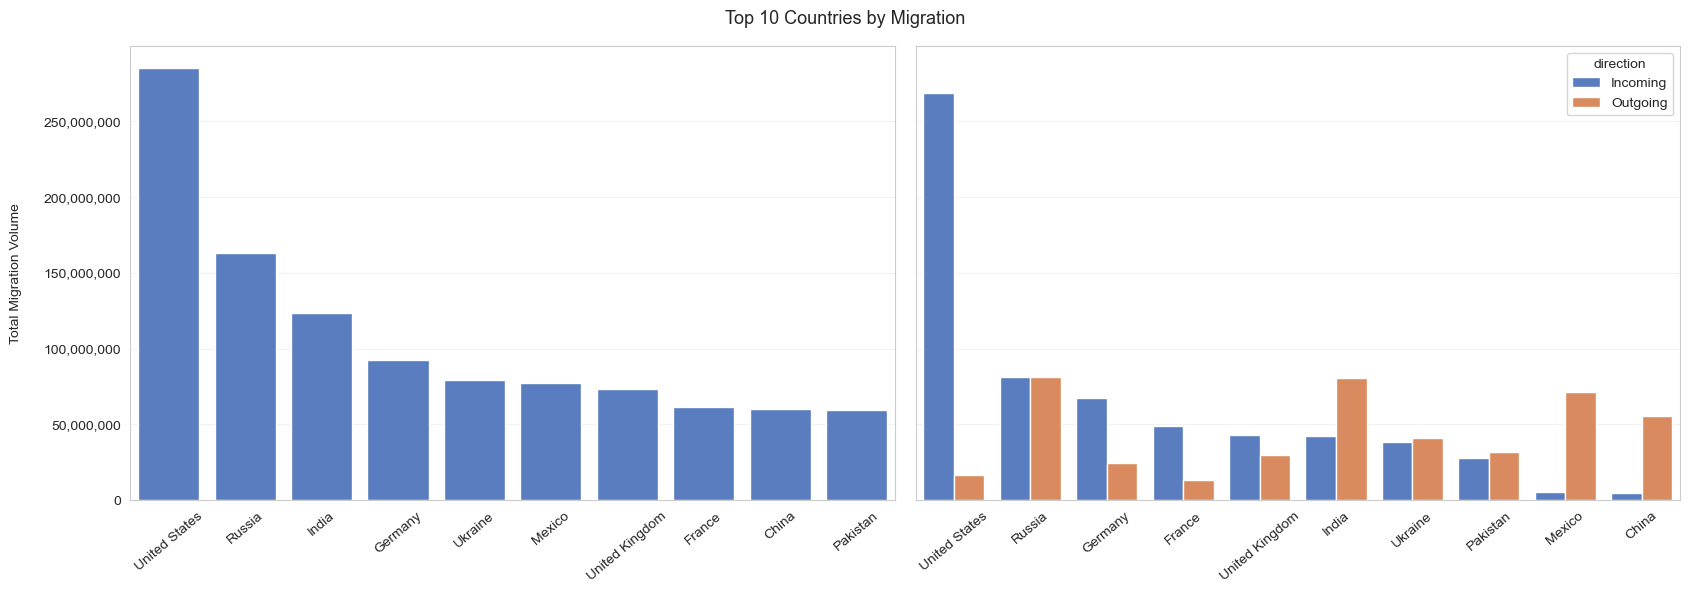

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

sns.barplot(data=top_10_totals, 
            x='country', 
            y='Total', 
            ax=ax1)

format_numbers(ax1)
ax1.tick_params(axis='x', rotation=40)
ax1.set_xlabel('')
ax1.set_ylabel('Total Migration Volume', labelpad=15)

# ---ax2
order = top_10_direction_comparison[top_10_direction_comparison['direction'] == 'Incoming'].sort_values('Total Migration Volume', ascending=False)['country']

sns.barplot(top_10_direction_comparison,
            x='country', 
            y='Total Migration Volume', 
            hue='direction', ax=ax2, 
            order=order)

format_numbers(ax2)
ax2.tick_params(axis='x', rotation=40)
ax2.set_xlabel('')

plt.suptitle('Top 10 Countries by Migration', size=13)
plt.tight_layout()

The dataset contains over 200 countries so for the sake of simplicity, I've narrowed down the country analysis to the top 10 countries by migration volume. The United States dominates global migration with approximately 285 million total migrants, predominantly incoming (268.8M incoming vs 16.8M outgoing), accounting for North America's position as the largest net receiver of migrants. Russia, ranking second with 163 million total migrants, shows a uniquely balanced migration pattern with nearly equal incoming and outgoing flows (81.5M each), contributing to Europe's relatively stable migration balance.

Looking at China and India helps explain Asia-Pacific's role as the primary sending region. Despite their massive populations, both show lower overall migration volumes than the US, but their strong outward flows - particularly China's ratio of 55.3M outgoing versus 4.9M incoming migrants - drive Asia-Pacific's position as the largest source of global migrants. These patterns, combined with the region's religious diversity, help explain both the high Buddhist growth rates globally and the increasing religious diversity we see in receiving regions.

Lastly, Latin America-Caribbean region's outward migration patterns are significantly influenced by Mexico, which shows heavily skewed patterns with 71.7M outgoing versus 5.7M incoming migrants. 

(Note: While geographically part of North America, Mexico is categorized as Latin America-Caribbean in this study, further emphasizing the United States' outsized role in North American migration patterns)

### How have major migration countries changed over time?

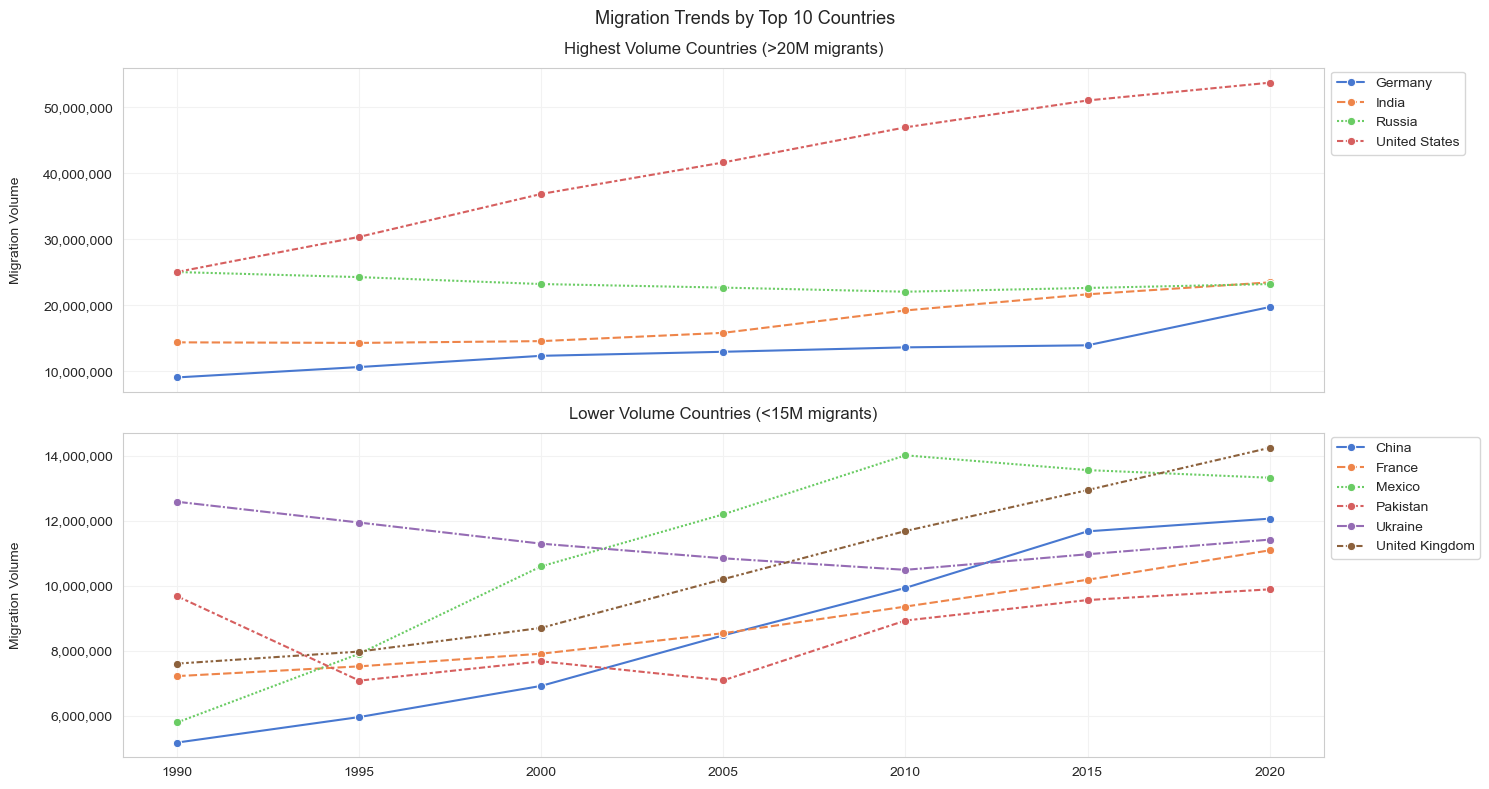

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

sns.lineplot(high_vol_trends, marker='o', ax=ax1)
format_numbers(ax1)
ax1.set_ylabel('Migration Volume', labelpad=15)
ax1.legend(title="", bbox_to_anchor=(1, 1.01))
ax1.set_title('Highest Volume Countries (>20M migrants)', pad=10)

#ax1.annotate('German refugee crisis', 
           #xy=(2015, 20000000),  # point to annotate
           #xytext=(2012, 25000000),  # text position
           #arrowprops=dict(facecolor='black', shrink=0.03))


sns.lineplot(low_vol_trends, marker='o', ax=ax2)
format_numbers(ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Migration Volume', labelpad=15)
ax2.legend(title="", bbox_to_anchor=(1, 1.01))
ax2.set_title('Lower Volume Countries (<15M migrants)', pad=10)

plt.suptitle('Migration Trends by Top 10 Countries', size=13)
plt.tight_layout()

While the United States has had large yet moderate growth, Russia saw its numbers shrink until they leveled out around 2010, having initially started at similar numbers to the U.S. India also emerged as a high migration country, with much of their movement being outward. The country experienced a surge in migration after 2005, reaching Russia's counts.

This looks very different for countries that have relatively lower levels of migration. Pakistan, in particular, has experienced the most turbulence over time, while France and the UK show steady overall increases. Mexico had consistently upwards movement until 2010, where numbers started to decline.

### What role does religion play in country-level migration?

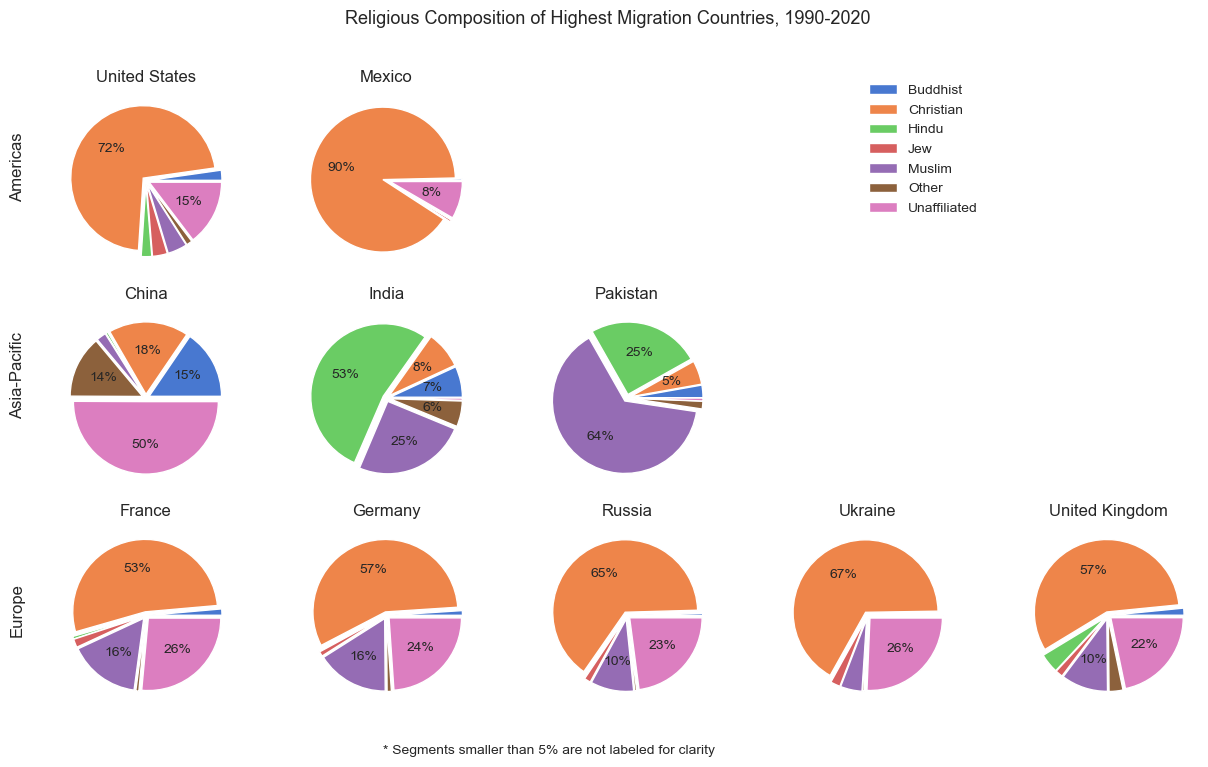

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 5, figsize=(15, 8))

# For North America/Latin Caribbean (first row)
for i, country in enumerate(north_america_latin):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax1[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']), explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
    ax1[i].set_title(country)

# For Asia Pacific (second row)
for i, country in enumerate(asia_pacific):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax2[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']), explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
    ax2[i].set_title(country)

# For Europe (third row)
for i, country in enumerate(europe):
    country_data = country_religion_composition[country_religion_composition['country'] == country]
    ax3[i].pie(country_data['percent'], labels=country_data['religion'], labeldistance=None, autopct=make_autopct(country_data['percent']), explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
    ax3[i].set_title(country) 


ax1[0].text(-.25, 0.4, 'Americas', rotation=90, transform=ax1[0].transAxes, size=12)
ax2[0].text(-.25, 0.4, 'Asia-Pacific', rotation=90, transform=ax2[0].transAxes, size=12)
ax3[0].text(-.25, 0.4, 'Europe', rotation=90, transform=ax3[0].transAxes, size=12)


# Removing unused subplots
plt.delaxes(ax2[3])
plt.delaxes(ax2[4])
plt.delaxes(ax1[2])
plt.delaxes(ax1[3])
plt.delaxes(ax1[4])

fig.text(x=0.35, y=0.05, s='* Segments smaller than 5% are not labeled for clarity', size=10)
plt.suptitle('Religious Composition of Highest Migration Countries, 1990-2020', size=13)
plt.legend(bbox_to_anchor=(-0.15, 3.5), edgecolor='white');

While migration volumes show where people move, religious composition data reveals who is moving. The Americas show predominantly Christian migration, with 90% in Mexico and 72% in the US. European countries have a similar pattern in their religious makeup, with Christian majorities (53-67%), and significant Muslim and Unaffiliated populations. Of these Christian dominant countries, the United States and the United Kingdom show a bit more religious variation.

The Asia-Pacific region is the most diverse: China is the most atypical with 50% Unaffiliated migrants. India and Pakistan present complementary profiles with Hindu (53%) and Muslim (64%) majorities respectively. Interestingly, each has substantial minorities of the other religion: 25% Muslim in India and 25% Hindu in Pakistan.

### How are religious demographics shifting within key countries?

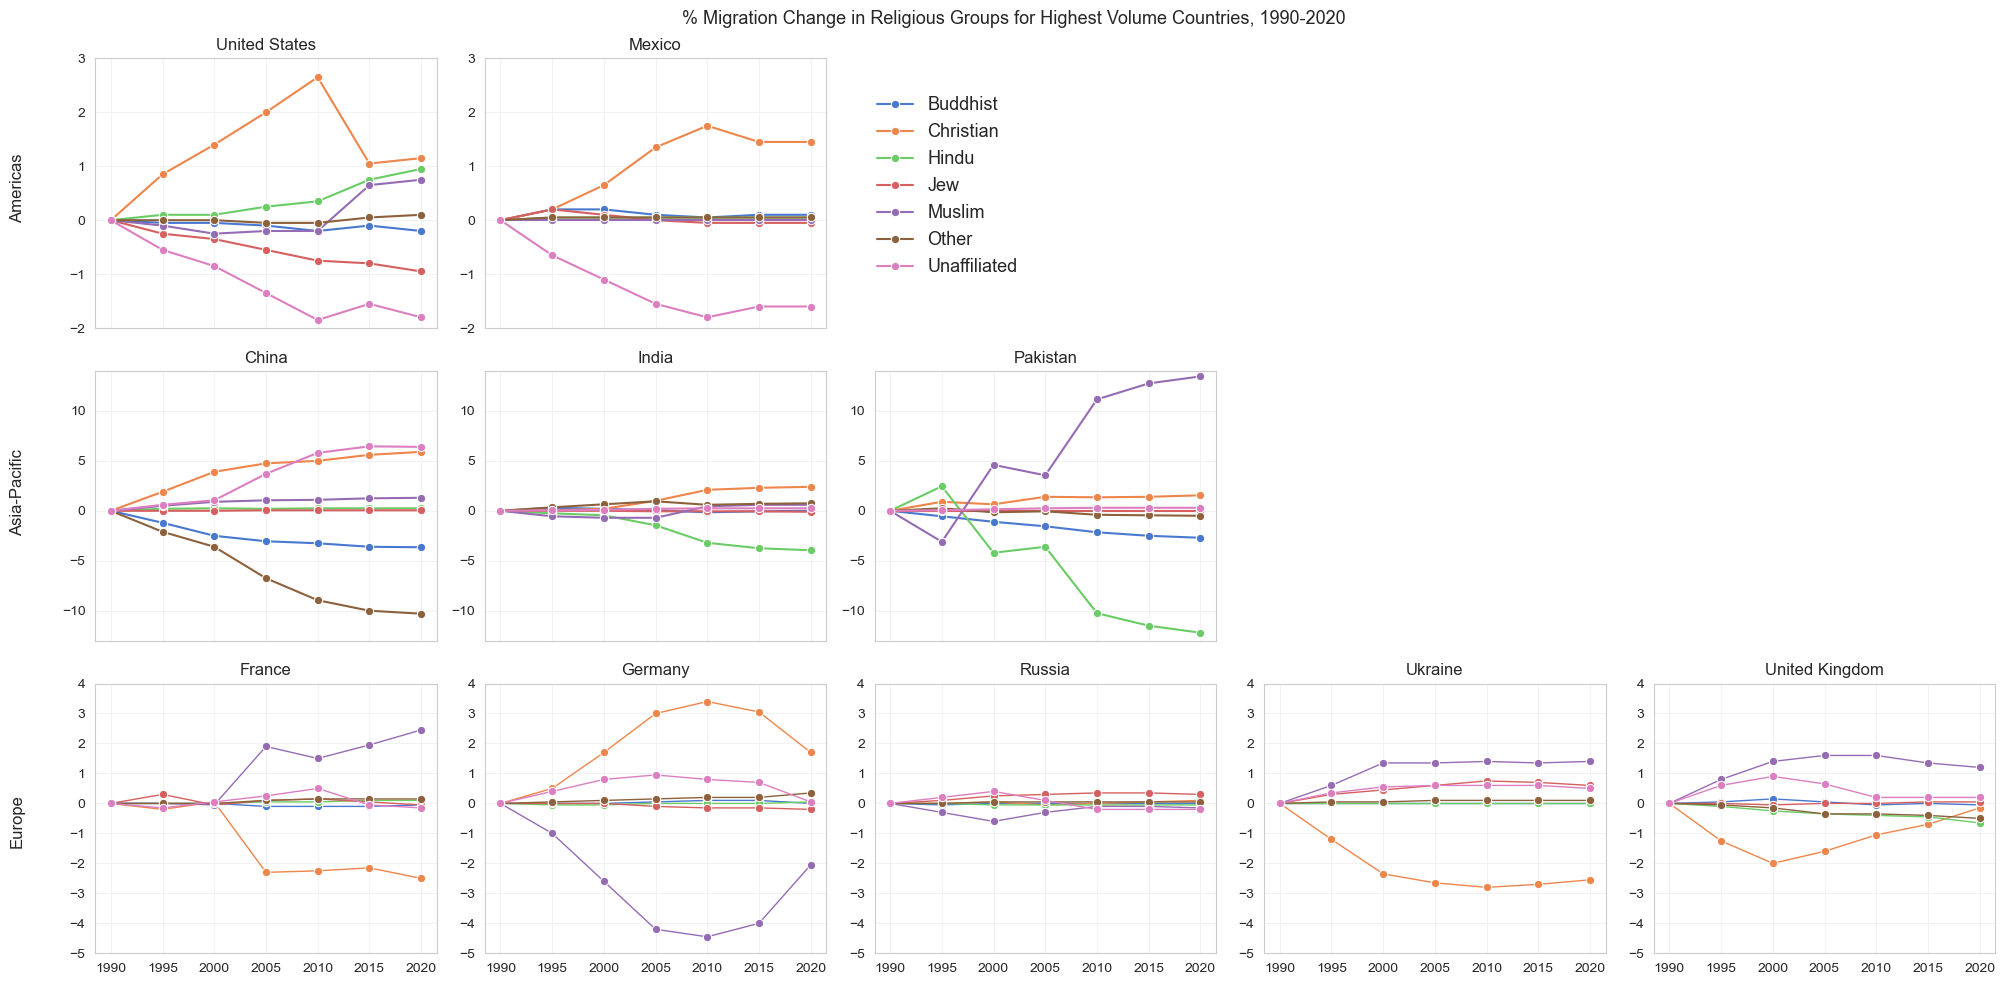

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 5, figsize=(20, 10), sharex=True)

for i, country in enumerate(north_america_latin):
    country_data = relative_change_df[relative_change_df['country'] == country]
    sns.lineplot(data=country_data, x='year', y='change_from_1990', hue='religion', legend=False, marker='o', errorbar=None, ax=ax1[i])
    ax1[i].set_title(country)
    ax1[i].set_xlabel('')
    ax1[i].set_ylabel('')
    ax1[i].set_ylim(-2, 3)
    
for i, country in enumerate(asia_pacific):
    country_data = relative_change_df[relative_change_df['country'] == country]
    sns.lineplot(data=country_data, x='year', y='change_from_1990', hue='religion', legend=False, marker='o', errorbar=None, ax=ax2[i])
    ax2[i].set_title(country)
    ax2[i].set_xlabel('')
    ax2[i].set_ylabel('')
    ax2[i].set_ylim(-13, 14)
    

for i, country in enumerate(europe):
    country_data = relative_change_df[relative_change_df['country'] == country]
    sns.lineplot(data=country_data, x='year', y='change_from_1990', hue='religion', legend=False, errorbar=None, marker='o', ax=ax3[i], linewidth=1)
    ax3[i].set_title(country)
    ax3[i].set_xlabel('')
    ax3[i].set_ylabel('')
    ax3[i].set_ylim(-5, 4)  

ax1[0].text(-.25, 0.4, 'Americas', rotation=90, transform=ax1[0].transAxes, size=12)
ax2[0].text(-.25, 0.4, 'Asia-Pacific', rotation=90, transform=ax2[0].transAxes, size=12)
ax3[0].text(-.25, 0.4, 'Europe', rotation=90, transform=ax3[0].transAxes, size=12)

fig.legend(religions, bbox_to_anchor=(0.51, 0.91), fontsize=13, edgecolor='white')

# Removing unused subplots
plt.delaxes(ax2[3])
plt.delaxes(ax2[4])
plt.delaxes(ax1[2])
plt.delaxes(ax1[3])
plt.delaxes(ax1[4])

plt.suptitle('% Migration Change in Religious Groups for Highest Volume Countries, 1990-2020', size=13)
plt.tight_layout()

Finally, looking at religious change at the country level helps to account for the global and regional trends that we have seen. The growing religious diversity of the United States reflects the growth we saw across many religious groups, especially the robust growth in Buddhist and Muslim immigration. The contrasting patterns between India and Pakistan illustrate how country-level shifts-such as Pakistan's Muslim growth and India's Hindu stability-contribute to the broader regional picture. These dynamics at the country level help explain why some religious groups-like Buddhists and Muslims-are showing such high growth rates globally while others, such as Hindus and Jews, are experiencing relatively modest growth.

Further, Pakistan, France, and Germany all exhibit similar patterns in the relative changes between their major religious groups - with Pakistan's strong Muslim growth being balanced by decline in its Hindu population, and France and Germany both showing a Christian decline being offset by Muslim growth. The data, then, might suggest a somewhat different story than the simple secularization narrative where traditional majorities decline somewhat, while remaining significant, and minority faiths gain greater presence in making societies more religiously diverse.

### What has thirty years years of religious migration shown us?

Taking everything into account, the story of religious migration from 1990 to 2020 reflects both persistent patterns and emerging shifts. While Christians remain the largest migrant group and North America continues as a primary destination, new dynamics have reshaped the global landscape. Buddhist migrants showed surprising growth, Muslim migration accelerated dramatically after 2005, and Asia-Pacific emerged as a major source region. These changes manifest uniquely at the country level - from the United States' growing religious diversity to the complementary Hindu-Muslim patterns between India and Pakistan. Rather than a simple story of demographic change, these trends reveal an increasingly interconnected world where traditional religious majorities remain significant even as societies become more diverse.